# K-means
Sean Wade

In [177]:
import numpy as np
from scipy.spatial import distance
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

In [180]:
class KMeans:
    """ My implementation of the K-means algorithms."""
    
    def fit(self, x_train, k=3):
        """ 
        Args:
          x_train : (np.ndarray) An NxD array array of points to cluster
          k : (int) The number of clusters
        """
        # Init Center Guess
        n, d = x_train.shape
        data_sigma = np.var(x_train, axis=0)
        data_mu = np.mean(x_train, axis=0)
        k_means = np.sqrt(data_sigma) * np.random.randn(k, d) + data_mu
        
        diff = np.inf
        while diff > 10e-5:
            prev_center = k_means.copy()
            # Calc Distance from all centers
            dist = [np.linalg.norm(x_train-center, axis=1) for center in k_means]
            dist = np.array(dist)
            # Group with the closest center
            group = np.argmin(dist, axis=0)
            # Recompute centers from group
            for i in range(k):
                k_means[i] = np.mean(x_train[np.where(group==i)], axis=0)
            diff = np.linalg.norm(k_means - prev_center)
            
        self.k_means = k_means
        self.k = k
                

    def predict(self, x_test):
        """
        Args:
          x_test : (np.ndarray) Points to classify
          
        Returns
          class : (np.ndarray) Which cluster points belong to:
        """
        dist = [np.linalg.norm(x_test-center, axis=1) for center in self.k_means]
        dist = np.array(dist)
        return np.argmin(dist, axis=0)
        


## Create Data

For demonstration we will create a synthetic dataset that is 300 points drawn from 3 different distributions.  The goal of kmeans is to find the center of each.

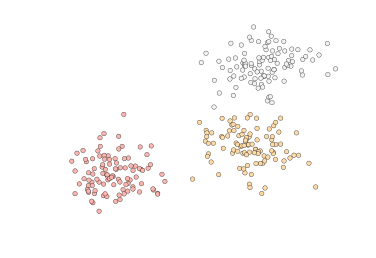

In [181]:
data, group = make_blobs(300)
plt.scatter(data[:,0], data[:,1], c=group, cmap=plt.cm.Pastel1)
plt.axis('off')
plt.show()

## Plot Results

In [182]:
model = KMeans()
model.fit(data, 3)

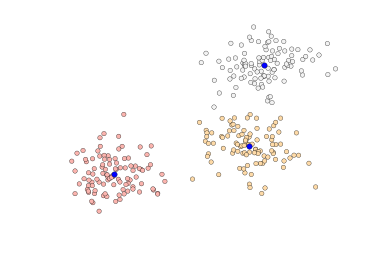

In [183]:
plt.scatter(data[:,0], data[:,1], c=group, cmap=plt.cm.Pastel1)
plt.scatter(model.k_means[:,0], model.k_means[:,1], c='b', s=30)
plt.axis('off')
plt.show()

#### Plot the Decision Boundary

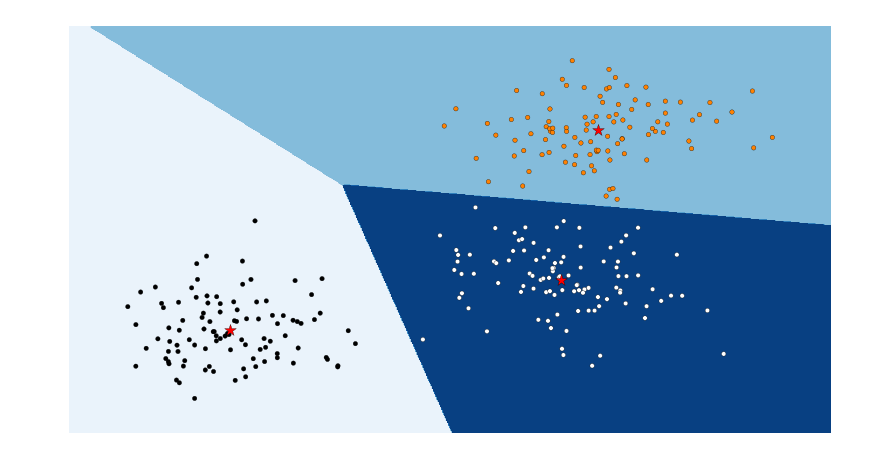

In [229]:
plt.figure(figsize=(15,8))
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
labels = model.predict(data)
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues)

# Plot also the training points
plt.scatter(data[:,0], data[:,1], c=labels, cmap=plt.cm.afmhot)
plt.scatter(model.k_means[:,0], model.k_means[:,1], marker='*', c='r', s=150)
plt.axis('off')
plt.show()